<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/digby1981.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digby (1981) to Model Rock Compressibilities with Respect to Pressure**

**Digby (1981) is valid for clastic sedimentary rocks (sandstone, chalk), not for carbonate**

Digby (1981) represented a rock as collection of grains with radius `r` and neighboring bonded particles with radius `a`. While **pore pressure** decreases, space `a` decreases to a new radius `b`. Digby (1981) used term **differential pressure** rather than pore pressure. Differential pressure (effective pressure) is confining pressure minus pore pressure: `P_eff = P_conf - Pp`. A new term, coordination number or `Cp` was also introduced. **Murphy (1982)** stated that `Cp` is proportional to `e^(1-porosity)`.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

### Step 1. Murphy (1982) to Compute Coordination Number

Murphy (1982) theory of proportionality of coordination number `Cp` and porosity. Supposing the real equation that relates both is `Cp = 11.759 * e^(1 - porosity) - 12.748` [(Li and Ma, 2019)](https://). 

Text(0, 0.5, 'Coordination number')

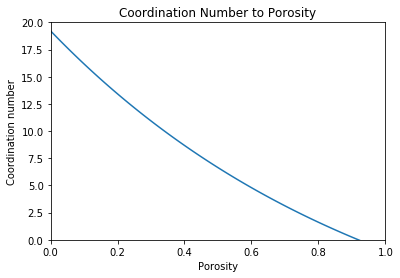

In [ ]:
poro_arr = np.linspace(0, 1, 100)
Cp_arr = 11.759 * np.exp(1 - poro_arr) - 12.748
plt.plot(poro_arr, Cp_arr)
plt.title('Coordination Number to Porosity')
plt.xlim(0, 1); plt.ylim(0, 20)
plt.xlabel('Porosity'); plt.ylabel('Coordination number')

### Step 2. Calculate Rock Properties (Mineral Bulk and Shear Incompressibility)

Supposing a sandstone has **50% porosity**, composed of **50% quartz** and **50% clay minerals**, and **Poisson's ratio of 0.4** (Typically sandstone has `poisson` between 0.1 and 0.4). Mineral bulk moduli (`Km`) and shear moduli (`Gm`) can be computed using **Voigt-Reuss-Hill method**. 

In [ ]:
# Voigt Reuss Hill to compute Km and Gm

rhocalc = 2.71; Kcalc = 76.8; Gcalc = 32
rhoclay = 2.58; Kclay = 20.9; Gclay = 6.9
rhodolo = 2.87; Kdolo = 94.9; Gdolo = 45
rhoqtz = 2.65; Kqtz = 36.6; Gqtz = 45
# mineral composition
calc = 0; clay = 0.5; dolo = 0; qtz = 0.5

mincomposition = np.array([calc, clay, dolo, qtz])
rhomineral = np.array([rhocalc, rhoclay, rhodolo, rhoqtz])
Kmineral = np.array([Kcalc, Kclay, Kdolo, Kqtz])
Kmineral_inv = 1 / Kmineral
Gmineral = np.array([Gcalc, Gclay, Gdolo, Kqtz])
Gmineral_inv = 1 / Gmineral

Kv = sum(mincomposition * Kmineral)
Kr_inv = sum(mincomposition * Kmineral_inv)
Gv = sum(mincomposition * Gmineral)
Gr_inv = sum(mincomposition * Gmineral_inv)
rhom = sum(mincomposition * rhomineral)
Km = (Kv+(1/Kr_inv)) / 2
Gm = (Gv+(1/Gr_inv)) / 2

print("Mineral bulk moduli:", Km, "GPa")
print("Mineral shear moduli:", Gm, "GPa")
print("Mineral density:", rhom, "g/cc")

Mineral bulk moduli: 27.678304347826085 GPa
Mineral shear moduli: 16.68051724137931 GPa
Mineral density: 2.615 g/cc


In [ ]:
poro = 0.5
Cp = 11.759 * np.exp(1 - poro) - 12.748
print("Rock coordination number:", Cp)

Rock coordination number: 6.639313422162809


The sandstone has mineral bulk moduli (`Km`) 27.68 GPa, shear moduli (`Gm`) 16.68 GPa, and coordination number (`Cp`) 6.64. 

### Step 3. Calculate Differential Pressure

Assuming the sandstone is confined to a pressure of `P_conf = 70 MPa` and the pore pressure is `Pp = 60 MPa`.  

In [ ]:
P_conf = 70 
Pp = 60
pressure = P_conf - Pp
print("Differential pressure:", pressure, "MPa")

Differential pressure: 10 MPa


### Step 4. Use Digby (1981) to Compute Dry Rock Incompressibility

Since radius `a` and `r` not known, we assume the rock has ratio of a and r (`ratio_ar`) is 1. We then compute dry rock incompressibility (`K_dry`) using **Digby (1981) method**. 

First, solve `d`. Second, calculate ratio of deformed radius `b` to `r` (`ratio_br`). Third, compute `K_dry`.

In [ ]:
"Digby (1981) Method"

# ratio_ar = np.linspace(0, 1, 100)
ratio_ar = 1

poisson = 0.4 # typical sandstone, high poisson ratio
Gm = 10 # shear moduli, in GPa
pressure = 10 # pressure, in MPa
Cp = 10

def f(d):
  f1 = (d**3) + (1.5 * (ratio_ar**2) * d) - ((3 * np.pi * (1 - poisson) * pressure) / (2 * Cp * (1 - poro) * Gm))
  return(f1)

d = fsolve(f, 1)

ratio_br = np.sqrt((d**2) + (ratio_ar**2))
Kdry = ((Cp * (1 - poro) * Gm) / (3 * np.pi * (1 - poisson))) * ratio_br
print("Dry bulk modulus:", Kdry, "GPa")

Dry bulk modulus: [9.36413669] GPa


### Step 5. Zimmermann (1986) to Compute Pore Compressibility

Use [(Zimmermann 1986)](https://() to compute pore incompressibility (`K_pore`) from the resulted `K_dry`. Then, invert `K_pore` to arrive at value of **pore compressibility** or the **formation compressibility** (`cf`). 

`cf` later is important in **reservoir engineering** since it determine the term **total compressibility as sum of formation compressibility and fluid compressibility** or `ct = cf + (sw * cw) + (so * co) + (sg * cg)`, although often negligible. 



```
sw, so, sg = water, oil, gas saturation
sw + so + sg = 1
cw, co, cg = water, oil, gas isothermal compressibility
```





In [ ]:
K_pore_inverse = (1 / (poro * Kdry)) - ((1 - poro) / (poro * Km))
cf = (1 / K_pore_inverse) / 145038 # from GPa^-1 to psi^-1
print("Pore compressibility:", cf, "psi^-1")

Pore compressibility: [3.88542625e-05] psi^-1


### Plot Change of Pore Compressibilities with Declining Pore Pressure

During production, assuming **pore pressure declines from 60 to 5 MPa**, at **confining pressure 70 MPa**. Sandstone with the same properties, plot the pore compressibility change with respect to declining pore pressure.

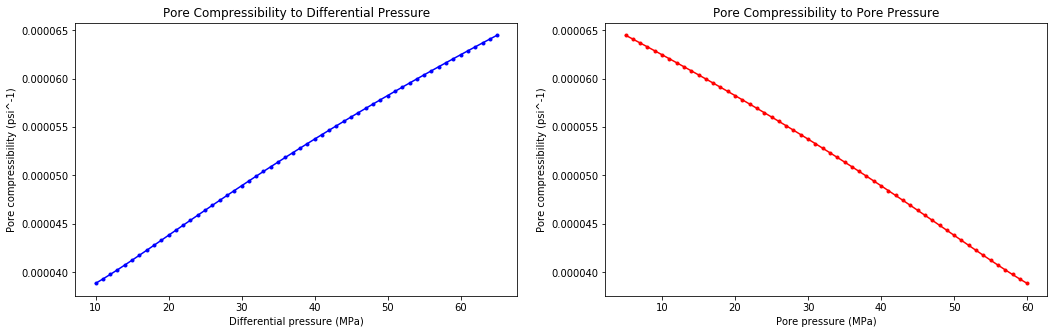

In [ ]:
P_conf - 70
Pp = np.arange(5, 61, 1)
pressure = P_conf - Pp

cf_arr = []

for i in range(len(pressure)):

  def f(d):
    f1 = (d**3) + (1.5 * (ratio_ar**2) * d) - ((3 * np.pi * (1 - poisson) * pressure[i]) / (2 * Cp * (1 - poro) * Gm))
    return(f1)
  d = fsolve(f, 1)
  
  ratio_br = np.sqrt((d**2) + (ratio_ar**2))
  Kdry = ((Cp * (1 - poro) * Gm) / (3 * np.pi * (1 - poisson))) * ratio_br

  K_pore_inverse = (1 / (poro * Kdry)) - ((1 - poro) / (poro * Km))
  cf = (1 / K_pore_inverse) / 145038 # from GPa^-1 to psi^-1
  cf_arr.append(float(cf))

# plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(pressure, cf_arr, '.-', color='blue')
plt.title('Pore Compressibility to Differential Pressure')
# plt.xlim(0, 1); plt.ylim(0, 20)
plt.xlabel('Differential pressure (MPa)'); plt.ylabel('Pore compressibility (psi^-1)')

plt.subplot(1, 2, 2)
plt.plot(Pp, cf_arr, '.-', color='red')
plt.title('Pore Compressibility to Pore Pressure')
# plt.xlim(0, 1); plt.ylim(0, 20)
plt.xlabel('Pore pressure (MPa)'); plt.ylabel('Pore compressibility (psi^-1)')

plt.tight_layout(pad=2.0) # set distance between two plots

**Conclusion**: In production, while pore pressure decreases, differential pressure increases, the **formation compressibility increases**, due to pore collapse. 

# ***

In [ ]:
# psi to GPa
C_formation = 5E-6 / 6.89E-6 # psi^-1 to GPa^-1
C_rock = C_formation / ((1 - poro) / poro)
K_rock = 1 / C_rock
K_rock

1.378